In [1]:
] activate ..

In [2]:
const IsingTc = 1/(1/2*log(1+sqrt(2)))

2.269185314213022

In [3]:
using Flux, HDF5, Images, RecursiveArrayTools, Plots
using Flux: crossentropy, onecold, onehotbatch, params, testmode!
using Printf, Statistics, LinearAlgebra
using Base.Iterators: partition

In [129]:
L = 8
Tleft = round(0.1, digits=3)
Tleft_test = round(0.1, digits=3)
Tright = round(5.0, digits=3)
Tright_test = round(5.0, digits=3)
h5open("Ising.h5", "r") do f
    cl = read(f["L$L/T$Tleft/confs"])
    cr = read(f["L$L/T$Tright/confs"])
    n = Int(size(cl, 3)/2)
    global confs_left = [(-1)^rand(Bool) .* cl[:,:,i] for i in n+1:2*n]
    global confs_right = [(-1)^rand(Bool) .* cr[:,:,i] for i in n+1:2*n]
    
    cl = read(f["L$L/T$(Tleft_test)/confs"])
    cr = read(f["L$L/T$(Tright_test)/confs"])
    global confs_left_test = [(-1)^rand(Bool) .* cl[:,:,i] for i in n+1:2*n]
    global confs_right_test = [(-1)^rand(Bool) .* cr[:,:,i] for i in n+1:2*n]
end

length(confs_left)

1000

In [130]:
h5open("Ising.h5", "r") do f
    global Ts = parse.(Float64, replace.(names(f["L$L/"]), Ref("T" => "")))
end

13-element Array{Float64,1}:
 0.1  
 0.644
 1.189
 1.733
 2.069
 2.269
 2.278
 2.469
 2.822
 3.367
 3.911
 4.456
 5.0  

In [131]:
printconfs(confs) = [Gray.(float.(confs[i])) for i in 1:100:length(confs)]

printconfs (generic function with 1 method)

,,,,,,,,,

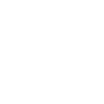
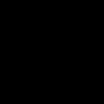
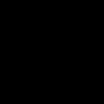
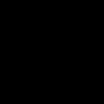
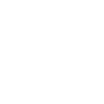
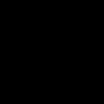
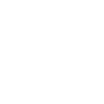
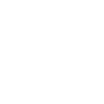
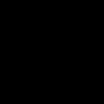
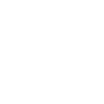

In [132]:
printconfs(confs_left)

,,,,,,,,,

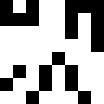
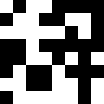
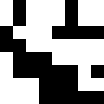
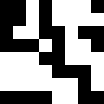
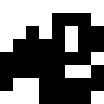
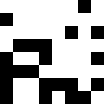
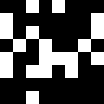
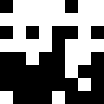
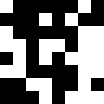
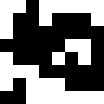

In [133]:
printconfs(confs_right)

# Prepare data for ML

In [134]:
nconfs_each = length(confs_left)
nconfs = 2*nconfs_each

2000

In [135]:
n_for_tests_each = floor(Int, nconfs_each * 0.25) # nconfs_each
n_for_tests = 2*n_for_tests_each

500

In [136]:
Neach = nconfs_each - n_for_tests_each # nconfs_each 
N = 2*Neach

1500

In [137]:
batch_size = 128
mb_idxs = partition(1:N, batch_size)

Base.Iterators.PartitionIterator{UnitRange{Int64}}(1:1500, 128)

In [138]:
# Bundle configurations together with phase labels and group into minibatches
# Outputs a batch (x, y) where x is in WHCN form, width x height x channels x N
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1], 1), size(X[1], 2), 1, length(idxs))
    for i in 1:length(idxs)
        @. X_batch[:, :, 1, i] = Float32(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:1)
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

In [139]:
confs_train = ArrayPartition(confs_left[1:Neach], confs_right[1:Neach]);
labels_train = vcat(fill(1, Neach), fill(0, Neach));

In [140]:
train_set = [make_minibatch(confs_train, labels_train, i) for i in mb_idxs];

nbatches = train_set |> length

12

In [141]:
confs_test = ArrayPartition(confs_left[end-n_for_tests_each+1:end], confs_right[end-n_for_tests_each+1:end]);
labels_test = vcat(fill(1, n_for_tests_each), fill(0, n_for_tests_each));

In [142]:
# confs_test = ArrayPartition(confs_left_test, confs_right_test);
# labels_test = vcat(fill(1, n_for_tests_each), fill(0, n_for_tests_each));

In [143]:
test_set = make_minibatch(confs_test, labels_test, 1:n_for_tests);

# Construct Convolutional Neural Network

In [144]:
# PrintSize() = x -> (@show size(x); x)
# Flatten() = x -> reshape(x, :, size(x, 4))

# const DIN = Int((L/2/2)^2 * 1) # with pad=(2,2)

# # conv -> maxpool -> conv -> maxpool -> dense -> dropout -> dense
# cnn = Chain(

#     Conv((2, 2), 1=>1, pad=(1,1), relu),

#     MaxPool((2,2)),

#     Conv((2, 2), 1=>1, pad=(1,1), relu),

#     MaxPool((2,2)),

#     Flatten(),

#     Dense(DIN, 256),

#     Dropout(0.5),
#     Dense(256, 2),

#     softmax
# )

In [163]:
Flatten() = x -> reshape(x, :, size(x, 4))

cnn = Chain(
    Flatten(),
    Dense(L^2, 100, relu),
#     Dropout(0.5),
    Dense(100, 2),
    softmax
)

Chain(getfield(Main, Symbol("##151#152"))(), Dense(64, 100, NNlib.relu), Dense(100, 2), NNlib.softmax)

In [164]:
# Compile CNN
@time cnn(train_set[1][1])
@time cnn(train_set[1][1])

  0.004766 seconds (7.60 k allocations: 528.413 KiB)
  0.000299 seconds (65 allocations: 105.203 KiB)


Tracked 2×128 Array{Float32,2}:
 0.396887  0.396887  0.396887  0.441814  …  0.396887  0.396887  0.396887
 0.603113  0.603113  0.603113  0.558186     0.603113  0.603113  0.603113

In [165]:
loss(x,y) = crossentropy(cnn(x),y) + sum(norm, params(cnn))

accuracy(x, y) = mean(onecold(cnn(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [159]:
opt = ADAM()

nepochs = 200

println("Initial loss: ", loss(test_set...))
println("Initial accuracy: ", accuracy(test_set...))
println()
println("------- Training .....")
best_acc = 0.0
last_improvement = 0
for epoch_idx in 1:nepochs
    @show epoch_idx
    flush(stdout)
    
    testmode!(cnn, false) # enable dropout layer
    Flux.train!(loss, params(cnn), train_set, opt)
    testmode!(cnn) # disable dropout layer

    # Calculate loss:
    l = loss(test_set...)
    println(@sprintf("[%d]: Test loss: %.4f", epoch_idx, l))
    
    # Calculate accuracy:
    acc = accuracy(test_set...)
    println(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))
    
    
    # Check if this is the best accuracy we've seen so far
    if acc >= best_acc
        best_acc = acc
        last_improvement = epoch_idx
    end
    
    # If our accuracy is good enough, quit out.
#     if acc >= 0.999
#         @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
#         break
#     end
    
    # If we haven't seen improvement in 5 epochs, drop our learning rate:
#     if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
#         opt.eta /= 10.0
#         @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

#         # After dropping learning rate, give it a few epochs to improve
#         last_improvement = epoch_idx
#     end

end
testmode!(cnn)
println("Done!")

Initial loss: 11.441203116185946 (tracked)
Initial accuracy: 0.72

------- Training .....
epoch_idx = 1
[1]: Test loss: 10.7096
[1]: Test accuracy: 0.7020
epoch_idx = 2
[2]: Test loss: 9.9116
[2]: Test accuracy: 0.7660
epoch_idx = 3
[3]: Test loss: 9.1393
[3]: Test accuracy: 0.8560
epoch_idx = 4
[4]: Test loss: 8.3987
[4]: Test accuracy: 0.8980
epoch_idx = 5
[5]: Test loss: 7.6789
[5]: Test accuracy: 0.9400
epoch_idx = 6
[6]: Test loss: 6.9744
[6]: Test accuracy: 0.9500
epoch_idx = 7
[7]: Test loss: 6.2900
[7]: Test accuracy: 0.9480
epoch_idx = 8
[8]: Test loss: 5.6225
[8]: Test accuracy: 0.9480
epoch_idx = 9
[9]: Test loss: 4.9752
[9]: Test accuracy: 0.9460
epoch_idx = 10
[10]: Test loss: 4.3552
[10]: Test accuracy: 0.9340
epoch_idx = 11
[11]: Test loss: 3.7617
[11]: Test accuracy: 0.9120
epoch_idx = 12
[12]: Test loss: 3.1922
[12]: Test accuracy: 0.8680
epoch_idx = 13
[13]: Test loss: 2.6569
[13]: Test accuracy: 0.7960
epoch_idx = 14
[14]: Test loss: 2.1572
[14]: Test accuracy: 0.714

[122]: Test loss: 0.6975
[122]: Test accuracy: 0.5000
epoch_idx = 123
[123]: Test loss: 0.6969
[123]: Test accuracy: 0.5000
epoch_idx = 124
[124]: Test loss: 0.6971
[124]: Test accuracy: 0.5000
epoch_idx = 125
[125]: Test loss: 0.6974
[125]: Test accuracy: 0.5000
epoch_idx = 126
[126]: Test loss: 0.6978
[126]: Test accuracy: 0.5000
epoch_idx = 127
[127]: Test loss: 0.6966
[127]: Test accuracy: 0.5000
epoch_idx = 128
[128]: Test loss: 0.6971
[128]: Test accuracy: 0.5000
epoch_idx = 129
[129]: Test loss: 0.6968
[129]: Test accuracy: 0.5000
epoch_idx = 130
[130]: Test loss: 0.6974
[130]: Test accuracy: 0.5000
epoch_idx = 131
[131]: Test loss: 0.6968
[131]: Test accuracy: 0.5000
epoch_idx = 132
[132]: Test loss: 0.6975
[132]: Test accuracy: 0.5000
epoch_idx = 133
[133]: Test loss: 0.6971
[133]: Test accuracy: 0.5000
epoch_idx = 134
[134]: Test loss: 0.6971
[134]: Test accuracy: 0.5000
epoch_idx = 135
[135]: Test loss: 0.6973
[135]: Test accuracy: 0.5000
epoch_idx = 136
[136]: Test loss: 0.

# Predict critical temperature

In [166]:
function loadconfs(filename, L, T)
    t = round(T, digits=3)
    h5open(filename, "r") do f
        c = read(f["L$L/T$t/confs"])
#         return [reshape(c[:,:,i], (L,L,1,1)) for i in 1:size(c, 3)]
        return Float32.(reshape(c, (L,L,1,:)))
    end
end

loadconfs (generic function with 1 method)

In [167]:
results = Dict{Float64, Vector{Float32}}()
for T in Ts
    confs = loadconfs("Ising.h5", L, T);
    out = cnn(confs)
    results[T] = vec(mean(out, dims=2).data)
end

results = sort(results)

OrderedCollections.OrderedDict{Float64,Array{Float32,1}} with 13 entries:
  0.1   => Float32[0.396893, 0.60311]
  0.644 => Float32[0.396893, 0.60311]
  1.189 => Float32[0.44119, 0.558812]
  1.733 => Float32[0.420173, 0.579828]
  2.069 => Float32[0.416659, 0.583341]
  2.269 => Float32[0.414671, 0.585328]
  2.278 => Float32[0.409555, 0.590445]
  2.469 => Float32[0.412656, 0.587344]
  2.822 => Float32[0.408665, 0.591335]
  3.367 => Float32[0.397246, 0.602754]
  3.911 => Float32[0.402213, 0.597787]
  4.456 => Float32[0.398061, 0.60194]
  5.0   => Float32[0.397896, 0.602103]

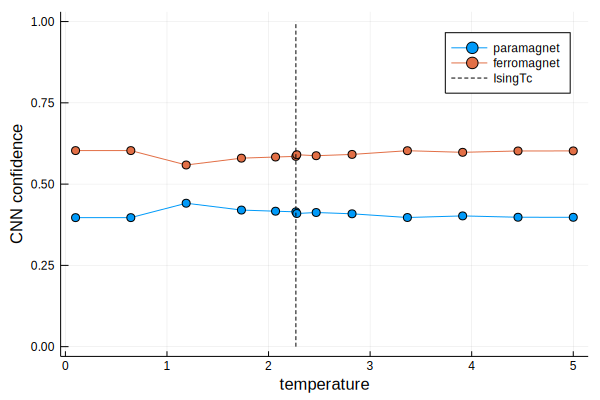

In [168]:
plot(keys(results) |> collect, reduce(hcat, values(results))',
    marker=:circle,
    xlab="temperature",
    ylabel="CNN confidence",
    labels=["paramagnet", "ferromagnet"]
)
plot!([IsingTc, IsingTc], [0, 1], ls=:dash, color=:black, label="IsingTc")